# Simulating Quantum Circuit using TensorFlow Quantum

Making a quantum circuit can be time-consuming, especially if there are too many qubits involved and the circuit is lengthy. In order to avoid the laborious process of building the circuits, we can use machine learning to design a machine learning model for such quantum circuits. Here we use Tensor flow quantum to simulate a custom quantum circuit which consists of several quantum gates.

The circuit consists of a Toffoli gate, a X gate, and two CNOT gates and 5 wires.

##  1 SETUP 

! pip install tensorflow==2.7.0

### 1. 1 Install TensorFlow Quantum:


! pip install tensorflow-quantum==0.7.2

### 1.2 Now import TensorFlow and the module dependencies:

In [909]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
from cirq.contrib.svg import SVGCircuit

## 2 Data

### 2.1 Classical data creation

At first, we create classical data by intializing binary numbers of 5 digits since we are creating a quantum circuit using 5 wires, then we can apply the equivalent classical gates to the binary numbers.

For instance TOFFOLI can be also described as mapping bits {a, b, c} to {a, b, c XOR (a AND b)} and CNOT can be described as mapping bits {a,b} to {a XOR b} and X gate can be expressed as mapping {a} to{NOT a}

So the measure of the wire 4  can be equivalently expressed as ¬(e ⊕ (a ∧ b)) ⊕ d ⊕ c	

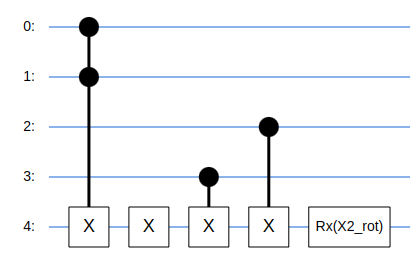

Create a  numpy array with required dimensions,here we work with dimension (32,6). Here we are dealing with 5 wires so we can create 2^5 =32 rows and 6 columns. The 6th column is for the result of the operation. We consider all 32 combinations.
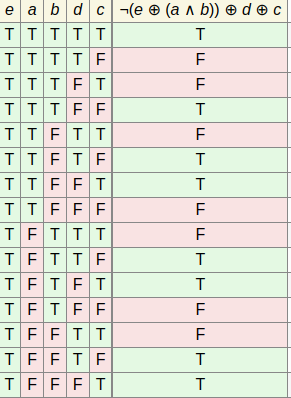

In [910]:
arr = np.zeros((32, 6))
n = 5
for i in range(32):
    b = bin(i)[2:].zfill(n)
    a =  [int(a) for a in str(b)]
    res = ((1-(a[4]^(a[0] & a[1])))^a[3])^a[2]
    a.append(res)
    data.append(a)
    for k in range(len(a)):
        arr[i][k] = int(a[k]) 

### 2.2 Encoding classical data to quantum data
There are advanced way to encode classical data in to quantum data like basis embedding, amplitude embedding and Qsample Encoding, which are the optimal ways for encoding but are quite complex. Here we keep the encoding process simple, by a simpler computational basis encoding which takes the binary for each qubit and flips it by applying the X gate. We use the cirq library which is built in tensor flow quantum and is natively supported in all TFQ operation. For instance for binary 00001,
```
    cir = cirq.Circuit()
    cir.append([cirq.I(qubits[0])])
    cir.append([cirq.I(qubits[1])])
    cir.append([cirq.I(qubits[2])])
    cir.append([cirq.I(qubits[3])])
    cir.append([cirq.X(qubits[4])])
```
Among the 32 combination we use first 16 as training set and the next 16 as the testing set and if the output is 0 then we label it as -1 and if the output is 1 then we label it as 1. It is labelled as so for the hinge loss, which we will use for training.

In [911]:
def make_data(qubits):
    train, train_label = [], []
    test,test_label = [], []
    row, col = arr.shape
    
    for i in range(0,15):
        cir = cirq.Circuit()
        for j in range(0,col-1):
            cir.append([cirq.I(qubits[j])]) if arr[i][j] ==0 else cir.append([cirq.X(qubits[j])])
        train.append(cir)
        train_label.append(-1) if arr[i][j+1]==0 else train_label.append(1)
        j=0
    for i in range(15,32):
        cir = cirq.Circuit()
        for j in range(0,col-1):
            cir.append([cirq.I(qubits[j])]) if arr[i][j] ==0 else cir.append([cirq.X(qubits[j])])
        test.append(cir)
        test_label.append(-1) if arr[i][j+1]==0 else test_label.append(1)
        j=0
    return tfq.convert_to_tensor(train), np.array(train_label), tfq.convert_to_tensor(train), np.array(train_label)

## 3 Model

### 3.1 Creating the circuit

We create the circuit using cirq and sympy, which we want to model for simulation. This circuit consists of 5 quantum gates, accepts list of qubits and returns the circuit according to the qubits.<br>
The configuration and sequence gates are as follows:
<br><br>
<table>
  <tr>
    <th>Sequence</th>
    <th>Gate</th>
    <th>Control</th>
    <th>Target</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Toffoli</td>
    <td>0,1</td>
    <td>4</td>
  </tr>
   <tr>
    <td>2</td>
    <td>X</td>
    <td>-</td>
    <td>4</td>
  </tr>
   <tr>
    <td>2</td>
    <td>CNOT</td>
    <td>3</td>
    <td>4</td>
  </tr>
   <tr>
    <td>3</td>
    <td>CNOT</td>
    <td>2</td>
    <td>4</td>
  </tr>
   <tr>
    <td>4</td>
    <td>RX</td>
    <td>-</td>
    <td>4</td>
  </tr>
</table>
<br>
The final RX rotation is arbitrary and is placed there for parametrization purpose only. The rotation gate also serves the function of reducing superposition in the input quantum data so that we can extract as much valuable information from the measurement as possible [https://arxiv.org/pdf/2003.02989.pdf].

While adding the TOFFOLI gate we could not directly add the TOFFOLI gate which requires three qubits due to the limitation of Tensor Flow Quantum which can only accept particular gates for serialization as of now. This is an open issue for now(https://github.com/tensorflow/quantum/pull/487).
The following gates are supported as of now.
```
[cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I]
```


So we used the subgate as CNOT with controls 1.

In [912]:
def make_circuit(qubits):
    x2 = sympy.symbols('X2_rot')
    c = cirq.Circuit(cirq.ControlledGate(sub_gate=cirq.CNOT, num_controls=1).on(qubits[0],qubits[1],qubits[4]))
    c.append([cirq.X(qubits[4])])
    c.append(cirq.CNOT(qubits[3],qubits[4]))
    c.append(cirq.CNOT(qubits[2],qubits[4]))
    c.append(cirq.rx(x2).on(qubits[4]))
    return c

### 3.2 Initializing the qubits

Using the cirq line qubits and line, we now initialize the qubits. Integer coordinate 'x', the only feature a qubit has, identifies the position of the qubit on the line. Here we initialize 5 qubits as we have 5 wires long circuit, then we test the circuit by making a trial circuit and printing it using cirq library's SVGCircuit.

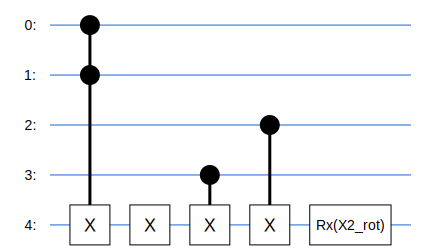

In [913]:
qubits = [cirq.LineQubit(i) for i in range(5)]
trial_circuit = make_circuit(qubits)
SVGCircuit(trial_circuit)

In [914]:
train, train_label, test, test_label = make_data(qubits)

### 3.3 Operators and inputs

In order to extract information from our circuit, we must apply measurement operators. We decide to undertake a Z measurement since the Pauli Z matrix establishes the framework for the measurement. Similar to a computational basis measurement, a Pauli Z basis measurement projects the state onto one of the states |0⟩ or |1⟩. 
<br> <br>
In order to observe an output, we must also feed our model quantum data, that is our line qubits that we initialized. 
<br> <br>
We are using standard keras input with type string.

In [915]:
measurement_operators = [cirq.Z(qubits[4])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

### 3.4 Using the PQC Layer

For training parameterized quantum models, we use PQC layer. This layer initializes the parameters and manages them in a Keras native manner given a parameterized circuit. The TFQ PQC layer requires the following attributes.
```
tfq.layers.PQC(
    model_circuit,
    operators,
    *,
    repetitions=None,
    backend='noiseless',
    differentiator=None,
    initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi),
    regularizer=None,
    constraint=None,
    **kwargs
)
```
We supply our circuit created with cirq and the Pauli'Z as measurement operator.Due to the probabilistic nature of measurement, the number of repetitions introduces variation between the two rows of data. We need a differentiator to define algorithms for computing the gradients of your circuits and we use the ParameterShift as it is a promising approach to evaluating gradients of parameterized
quantum circuits on quantum hardware[https://arxiv.org/pdf/1905.13311.pdf]. Finally, we use the initializer keras zeros initializer.


In [916]:
layer1 = tfq.layers.PQC(make_circuit(qubits), measurement_operators, repetitions = 32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)

In [917]:
model = tf.keras.models.Model(inputs=inputs, outputs=layer1)

## 4 Compiling and Fitting

### 4.1 Compiling the model

Now we compile the model with Adam optimizer and learning rate of 0.005 and hinge loss as it is convex and is suitable for classification of data. We for accuracy we use the deafult tensorflow keras accuracy.

In [918]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.003), loss=tf.keras.losses.hinge, metrics=[tf.keras.metrics.Accuracy()])

### 4.2 Fitting

We fit the model using the train and test data with a epochs of 512 and batch size of 4. We are choosing the batch size of 4 as  too large of a batch size will lead to poor generalization as our data is limited and same for the epochs.

In [919]:
history = model.fit(train, train_label, epochs=512, batch_size=4, validation_data=(test, test_label))

Epoch 1/512
4/4 [==============================] - 0s 40ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 2/512
4/4 [==============================] - 0s 11ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 3/512
4/4 [==============================] - 0s 11ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 4/512
4/4 [==============================] - 0s 11ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 5/512
4/4 [==============================] - 0s 11ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 6/512
4/4 [==============================] - 0s 10ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss: 2.0000 - val_accuracy: 0.0000e+00
Epoch 7/512
4/4 [==============================] - 0s 11ms/step - loss: 2.0000 - accuracy: 0.0000e+00 - val_loss

4/4 [==============================] - 0s 11ms/step - loss: 1.6750 - accuracy: 0.0000e+00 - val_loss: 1.7000 - val_accuracy: 0.0000e+00
Epoch 57/512
4/4 [==============================] - 0s 10ms/step - loss: 1.6542 - accuracy: 0.0000e+00 - val_loss: 1.6917 - val_accuracy: 0.0000e+00
Epoch 58/512
4/4 [==============================] - 0s 11ms/step - loss: 1.6542 - accuracy: 0.0000e+00 - val_loss: 1.6583 - val_accuracy: 0.0000e+00
Epoch 59/512
4/4 [==============================] - 0s 10ms/step - loss: 1.6667 - accuracy: 0.0000e+00 - val_loss: 1.6208 - val_accuracy: 0.0000e+00
Epoch 60/512
4/4 [==============================] - 0s 10ms/step - loss: 1.6667 - accuracy: 0.0000e+00 - val_loss: 1.6250 - val_accuracy: 0.0000e+00
Epoch 61/512
4/4 [==============================] - 0s 10ms/step - loss: 1.6250 - accuracy: 0.0000e+00 - val_loss: 1.6000 - val_accuracy: 0.0000e+00
Epoch 62/512
4/4 [==============================] - 0s 11ms/step - loss: 1.6458 - accuracy: 0.0000e+00 - val_loss: 1.62

Epoch 111/512
4/4 [==============================] - 0s 10ms/step - loss: 0.7333 - accuracy: 0.0000e+00 - val_loss: 0.7458 - val_accuracy: 0.0000e+00
Epoch 112/512
4/4 [==============================] - 0s 10ms/step - loss: 0.7292 - accuracy: 0.0000e+00 - val_loss: 0.6792 - val_accuracy: 0.0000e+00
Epoch 113/512
4/4 [==============================] - 0s 11ms/step - loss: 0.7375 - accuracy: 0.0000e+00 - val_loss: 0.7458 - val_accuracy: 0.0000e+00
Epoch 114/512
4/4 [==============================] - 0s 10ms/step - loss: 0.6833 - accuracy: 0.0000e+00 - val_loss: 0.6083 - val_accuracy: 0.0000e+00
Epoch 115/512
4/4 [==============================] - 0s 11ms/step - loss: 0.6708 - accuracy: 0.0000e+00 - val_loss: 0.6875 - val_accuracy: 0.0000e+00
Epoch 116/512
4/4 [==============================] - 0s 10ms/step - loss: 0.6583 - accuracy: 0.0000e+00 - val_loss: 0.6583 - val_accuracy: 0.0000e+00
Epoch 117/512
4/4 [==============================] - 0s 10ms/step - loss: 0.5792 - accuracy: 0.0000e

Epoch 166/512
4/4 [==============================] - 0s 10ms/step - loss: 0.1625 - accuracy: 0.1333 - val_loss: 0.2083 - val_accuracy: 0.0667
Epoch 167/512
4/4 [==============================] - 0s 11ms/step - loss: 0.1750 - accuracy: 0.0667 - val_loss: 0.1417 - val_accuracy: 0.0667
Epoch 168/512
4/4 [==============================] - 0s 11ms/step - loss: 0.1917 - accuracy: 0.0667 - val_loss: 0.1750 - val_accuracy: 0.0667
Epoch 169/512
4/4 [==============================] - 0s 10ms/step - loss: 0.2042 - accuracy: 0.0667 - val_loss: 0.1833 - val_accuracy: 0.0000e+00
Epoch 170/512
4/4 [==============================] - 0s 10ms/step - loss: 0.1500 - accuracy: 0.0667 - val_loss: 0.1625 - val_accuracy: 0.0667
Epoch 171/512
4/4 [==============================] - 0s 11ms/step - loss: 0.1250 - accuracy: 0.1333 - val_loss: 0.1708 - val_accuracy: 0.1333
Epoch 172/512
4/4 [==============================] - 0s 10ms/step - loss: 0.1250 - accuracy: 0.0000e+00 - val_loss: 0.1333 - val_accuracy: 0.066

4/4 [==============================] - 0s 10ms/step - loss: 0.0292 - accuracy: 0.6000 - val_loss: 0.0250 - val_accuracy: 0.6667
Epoch 224/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0250 - accuracy: 0.6667 - val_loss: 0.0292 - val_accuracy: 0.6000
Epoch 225/512
4/4 [==============================] - 0s 12ms/step - loss: 0.0167 - accuracy: 0.8000 - val_loss: 0.0083 - val_accuracy: 0.8667
Epoch 226/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0167 - accuracy: 0.7333 - val_loss: 0.0208 - val_accuracy: 0.6667
Epoch 227/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0458 - accuracy: 0.6000 - val_loss: 0.0208 - val_accuracy: 0.6667
Epoch 228/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0333 - accuracy: 0.6000 - val_loss: 0.0250 - val_accuracy: 0.6667
Epoch 229/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0208 - accuracy: 0.6667 - val_loss: 0.0167 - val_accuracy: 0.7333
Epoch 230/512
4/4 [=

4/4 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.9333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 281/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 282/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0083 - accuracy: 0.8667 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 283/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 0.9333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 284/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0083 - accuracy: 0.8667 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 285/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 286/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - v

4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 336/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 337/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 338/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 339/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 340/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 341/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss

Epoch 390/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 391/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 392/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 393/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 394/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 395/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 396/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0

4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 445/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 446/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 447/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 448/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 449/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 450/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss

Epoch 499/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 500/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 501/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 502/512
4/4 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 503/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 504/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 505/512
4/4 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0

## 5 Analyzing

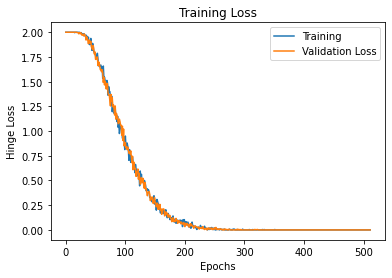

In [920]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Hinge Loss")
plt.show()


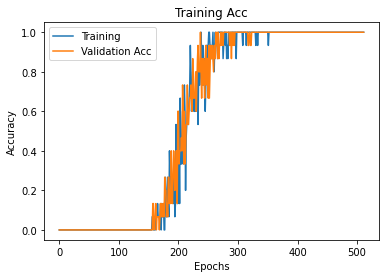

In [921]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.legend()
plt.title("Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()